In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import module as mod

from keras.layers import Dropout, Layer, LSTM, Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K

#from kerashypetune import KerasGridSearch

This notebook is an adaptation of the following Git repository : https://github.com/cerlymarco/MEDIUM_NoteBook/tree/master/Time2Vec

# 0. Load and prepare our dataset
First we'll load our datasets

In [2]:
### READ DATA ###

house1_power_blk2 = mod.load_dataset('../Exploratory Data Analysis/data/house1_power_blk2_labels.zip').resample('1min').mean()
house1_power_blk2['activity'] = (house1_power_blk2['activity'] > 0.5).astype(int)
house2_power_blk1 = mod.load_dataset('../Exploratory Data Analysis/data/house2_power_blk1_labels.zip').resample('1min').mean()
house2_power_blk1['activity'] = (house2_power_blk1['activity'] > 0.5).astype(int)
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,476.516667,0,0.000000
2016-03-06 00:01:00,477.733333,0,0.016667
2016-03-06 00:02:00,477.600000,0,0.033333
2016-03-06 00:03:00,477.716667,0,0.050000
2016-03-06 00:04:00,476.550000,0,0.066667


We'll normalize each dataset with a ```MinMaxScaler``` fitted on 70% of each dataset which we'll use a train set. After a few tests, normalizing the electrical power data is necessary to get better results for our final classification, more specifically to use one house as a training dataset and another as a testing dataset.

In [3]:
### SCALE THE DATASETS ###
# scale the dataset
scaler = MinMaxScaler()
train_dim_h1 = int(0.7*len(house2_power_blk1))
train_dim_h2 = int(0.7*len(house2_power_blk1))

scaler.fit(house1_power_blk2['mains'].iloc[:train_dim_h1].values.reshape(-1, 1))
house1_power_blk2['mains'] = scaler.transform(house1_power_blk2['mains'].values.reshape(-1, 1))

scaler.fit(house2_power_blk1['mains'].iloc[:train_dim_h2].values.reshape(-1, 1))
house2_power_blk1['mains'] = scaler.transform(house2_power_blk1['mains'].values.reshape(-1, 1))

house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,0.025055,0,0.000000
2016-03-06 00:01:00,0.025182,0,0.016667
2016-03-06 00:02:00,0.025168,0,0.033333
2016-03-06 00:03:00,0.025181,0,0.050000
2016-03-06 00:04:00,0.025059,0,0.066667


In [4]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 60

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

# 1. Train our embeddings

Next we need to prepare the data in batches for Keras.

In [86]:
### HOUSE 1 ###
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, sequence_length, ['mains']):
    X_h1.append(sequence)
    
for sequence in gen_labels(house1_power_blk2, sequence_length, ['mains']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [87]:
### HOUSE 2 ###

# prepare the batches
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, sequence_length, ['mains']):
    X_h2.append(sequence)
    
for sequence in gen_labels(house2_power_blk1, sequence_length, ['mains']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [88]:
### TRAIN TEST SPLIT HOUSE 1 ###
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(63461, 60, 1) (63461, 1)
(27139, 60, 1) (27139, 1)


In [89]:
### TRAIN TEST SPLIT HOUSE 2 ###

X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(59513, 60, 1) (59513, 1)
(25447, 60, 1) (25447, 1)


In [9]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [70]:
### DEFINE MODEL STRUCTURES ###

# def set_seed(seed):
    
#     tf.random.set_seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     random.seed(seed)

def T2V_NN(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    x = T2V(param['t2v_dim'])(inp)
    x = Dropout(0.2)(x)
    x = LSTM(param['unit'], activation=param['act'], return_sequences=False)(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam') #Adam(learning_rate=param['lr'])
    
    return m

In [71]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

early_stop = EarlyStopping(patience=3, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

best_params = {'unit': 32, 't2v_dim': 128, 'lr': 0.001, 'act': 'relu', 'epochs': 20, 'batch_size': 1024}
kgs_t2v = T2V_NN(param=best_params, dim=sequence_length)
kgs_t2v.summary();

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 t2v_7 (T2V)                 (None, 60, 129)           7928      
                                                                 
 dropout_7 (Dropout)         (None, 60, 129)           0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                20736     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 28,697
Trainable params: 28,697
Non-trainable params: 0
_________________________________________________________________


In [72]:
### TRAIN MODEL ON HOUSE 1 ###
kgs_t2v.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/20
59/59 [==============================] - 4s 59ms/step - loss: 0.2698
Epoch 2/20
59/59 [==============================] - 3s 58ms/step - loss: 0.2158
Epoch 3/20
59/59 [==============================] - 3s 59ms/step - loss: 0.1507
Epoch 4/20
59/59 [==============================] - 4s 64ms/step - loss: 0.1228
Epoch 5/20
59/59 [==============================] - 4s 61ms/step - loss: 0.1208
Epoch 6/20
59/59 [==============================] - 4s 61ms/step - loss: 0.1196
Epoch 7/20
59/59 [==============================] - 4s 60ms/step - loss: 0.1191
Epoch 8/20
59/59 [==============================] - 3s 59ms/step - loss: 0.1189
Epoch 9/20
59/59 [==============================] - 3s 59ms/step - loss: 0.1181
Epoch 10/20
59/59 [==============================] - 4s 60ms/step - loss: 0.1180
Epoch 11/20
59/59 [==============================] - 3s 59ms/step - loss: 0.1178
Epoch 12/20
59/59 [==============================] - 3s 59ms/step - loss: 0.1180
Epoch 13/20
59/59 [==================

In [91]:
### MSE ON HOUSE 1 ###
y_pred_h1 = kgs_t2v.predict(X_test_h1)
mean_absolute_error(y_test_h1.ravel(), y_pred_h1.ravel())

0.8385462428292341

In [92]:
### MSE ON HOUSE 2 ###
y_pred_h2 = kgs_t2v.predict(X_test_h2)
mean_absolute_error(y_test_h2.ravel(), y_pred_h2.ravel())

0.4722016191950244

In [73]:
### SAVE/LOAD THE T2V LAYER ###
t2v_weights = kgs_t2v.layers[1].get_weights()
#pickle.dump(t2v_weights, open('t2v_weights_norm_lstm_house1.pkl', 'wb'))
#t2v_weights = pickle.load(open('t2v_weights_norm_lstm_house1.pkl', 'rb'))
#kgs_t2v.layers[1].set_weights(t2v_weights)

# to disable fine-tuning
#kgs_t2v.layers[1].trainable = False

In [15]:
### TRAIN MODEL ON HOUSE 2 ###
kgs_t2v.fit(X_train_h2, y_train_h2, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

# save the weights
t2v_weights = kgs_t2v.layers[1].get_weights()
#pickle.dump(t2v_weights, open('t2v_weights_norm_house2.pkl', 'wb'))

Epoch 1/20
59/59 [==============================] - 1s 7ms/step - loss: 0.0047
Epoch 2/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 3/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 4/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 5/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 6/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 7/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0041


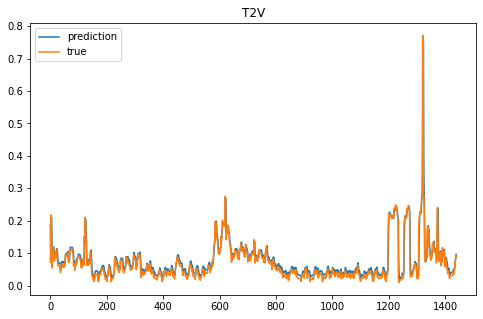

In [16]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 1 ###

plt.figure(figsize=(8,5))

plt.plot(y_pred_h1.ravel()[:24*60], label='prediction')
plt.plot(y_test_h1.ravel()[:24*60], label='true')
plt.title('T2V');
plt.legend();

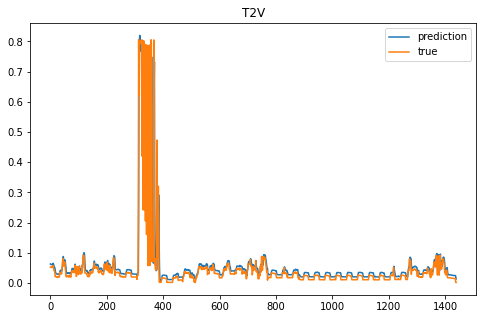

In [17]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 ###

plt.figure(figsize=(8,5))

plt.plot(y_pred_h2.ravel()[:24*60], label='prediction')
plt.plot(y_test_h2.ravel()[:24*60], label='true')
plt.title('T2V');
plt.legend();

Now that our Time2Vec model is trained, we can use its embedding as a first layer of neural network for a binary classification task.

# 2. Using our embeddings for classification

In [52]:
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, sequence_length, ['mains']):
    X_h2.append(sequence)
    
for sequence in gen_labels(house2_power_blk1, sequence_length, ['activity']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [53]:
### TRAIN TEST SPLIT ###

train_dim_h2 = int(0.7*len(house2_power_blk1))
X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(59513, 60, 1) (59513, 1)
(25447, 60, 1) (25447, 1)


In [56]:
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, sequence_length, ['mains']):
    X_h1.append(sequence)
    
for sequence in gen_labels(house1_power_blk2, sequence_length, ['activity']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [57]:
### TRAIN TEST SPLIT ###

train_dim_h1 = int(0.7*len(house1_power_blk2))
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(63461, 60, 1) (63461, 1)
(27139, 60, 1) (27139, 1)


In [58]:
### RE-DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [59]:
### DEFINE CLASSIFICATION MODEL STRUCTURES ###

def T2V_NN_C(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    x = T2V(param['t2v_dim'])(inp)
    x = Dropout(0.2)(x)
    x = LSTM(param['unit'], activation=param['act'], return_sequences=False)(x)
    # we want to make a classification with 2 classes
    x = Dense(1, activation='sigmoid')(x)
    
    m = Model(inp, x)
    m.compile(loss='bce', optimizer='adam') #Adam(learning_rate=param['lr'])
    
    return m

In [66]:
### LOAD OUR WEIGHTS ###
#t2v_weights = pickle.load(open('t2v_weights_norm_lstm_house1.pkl', 'rb'))


early_stop = EarlyStopping(patience=5, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)
best_params = {'unit': 32, 't2v_dim': 128, 'epochs': 12, 'act': 'relu', 'batch_size': 1024}
kgs_t2v_c = T2V_NN_C(param=best_params, dim=sequence_length)

kgs_t2v_c.layers[1].set_weights(t2v_weights)

# to ensable fine-tuning
kgs_t2v_c.layers[1].trainable = True

kgs_t2v_c.summary();

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 t2v_6 (T2V)                 (None, 60, 129)           7928      
                                                                 
 dropout_6 (Dropout)         (None, 60, 129)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                20736     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 28,697
Trainable params: 28,697
Non-trainable params: 0
_________________________________________________________________


Let's train our model on house 2.

In [67]:
kgs_t2v_c.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/12
62/62 [==============================] - 5s 58ms/step - loss: 0.6001
Epoch 2/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4921
Epoch 3/12
62/62 [==============================] - 4s 58ms/step - loss: 0.4829
Epoch 4/12
62/62 [==============================] - 4s 58ms/step - loss: 0.4662
Epoch 5/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4321
Epoch 6/12
62/62 [==============================] - 4s 60ms/step - loss: 0.4186
Epoch 7/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4167
Epoch 8/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4152
Epoch 9/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4112
Epoch 10/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4092
Epoch 11/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4075
Epoch 12/12
62/62 [==============================] - 4s 59ms/step - loss: 0.4070


We can now make predictions and have a look at the performances. The model has been trained on house 2 so first let's have a look at the score on the test dataset from house 2.

Score f_beta : 67.192%
Score accuracy : 68.338%


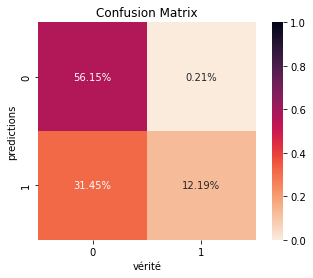

In [68]:
y_pred_h2 = kgs_t2v_c.predict(X_test_h2)
mod.plot_confusion_matrix(y_test_h2.ravel(), (y_pred_h2.ravel()>0.5).astype(int));

Now let's have a look at the score on the test dataset from house 1.

Score f_beta : 77.065%
Score accuracy : 77.280%


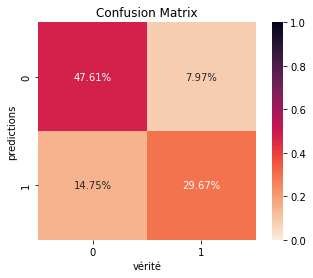

In [69]:
y_pred_h1 = kgs_t2v_c.predict(X_test_h1)
mod.plot_confusion_matrix(y_test_h1.ravel(), (y_pred_h1.ravel()>0.5).astype(int));

Finally we can try to plot our predictions.

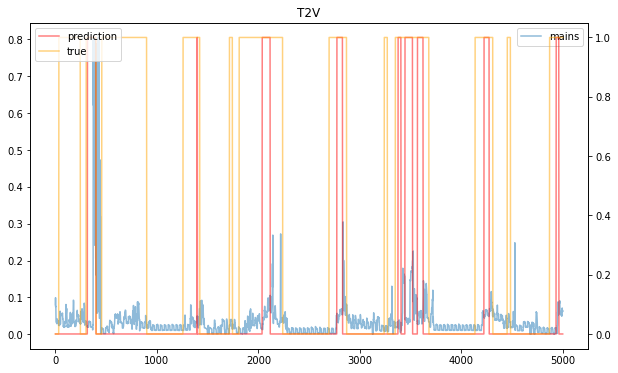

In [74]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 ###

fig, ax = plt.subplots(1,1 , figsize=(10,6))
axs = ax.twinx()

ax.plot(X_test_h2[:5000,0], label='mains', alpha=0.5)
axs.plot(y_pred_h2[:5000,0]>0.5, label='prediction', color='red', alpha=0.5)
axs.plot(y_test_h2[:5000,0], label='true', color='orange', alpha=0.5)
plt.title('T2V');
ax.legend(loc='upper right');
axs.legend(loc='upper left');

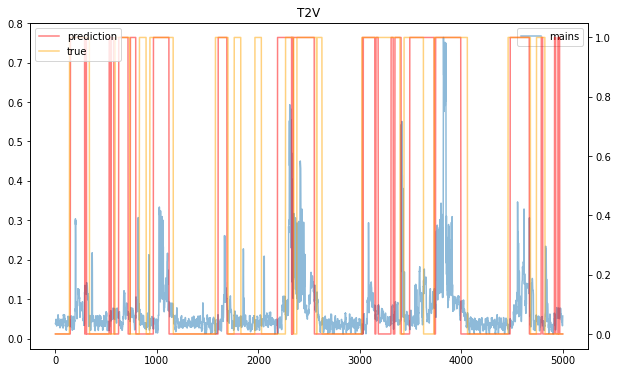

In [75]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 1 ###

fig, ax = plt.subplots(1,1 , figsize=(10,6))
axs = ax.twinx()

ax.plot(X_test_h1[:5000,0], label='mains', alpha=0.5)
axs.plot((y_pred_h1[:5000,0]>0.5), label='prediction', color='red', alpha=0.5)
axs.plot(y_test_h1[:5000,0], label='true', color='orange', alpha=0.5)
plt.title('T2V');
ax.legend(loc='upper right');
axs.legend(loc='upper left');

Looking at the plots, it looks like our model sucessfully identifies the period of times with a lot of variation on the load curve.

In [76]:
house1_power_blk2_res = house1_power_blk2.copy()
house1_power_blk2_res['activity_pred'] = np.nan
house1_power_blk2_res['activity_pred'].iloc[train_dim_h1:-60] = (y_pred_h1[:, 0].reshape(-1) > 0.5).astype(int)
house1_power_blk2_res.iloc[train_dim_h1:-60].head()

/home/pierre/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,mains,activity,hour,activity_pred
datetime,,,,
2016-04-19 01:41:00,0.038257,0,1.683333,0.0
2016-04-19 01:42:00,0.036625,0,1.700000,0.0
2016-04-19 01:43:00,0.037153,0,1.716667,0.0
2016-04-19 01:44:00,0.038520,0,1.733333,0.0
2016-04-19 01:45:00,0.045619,0,1.750000,0.0


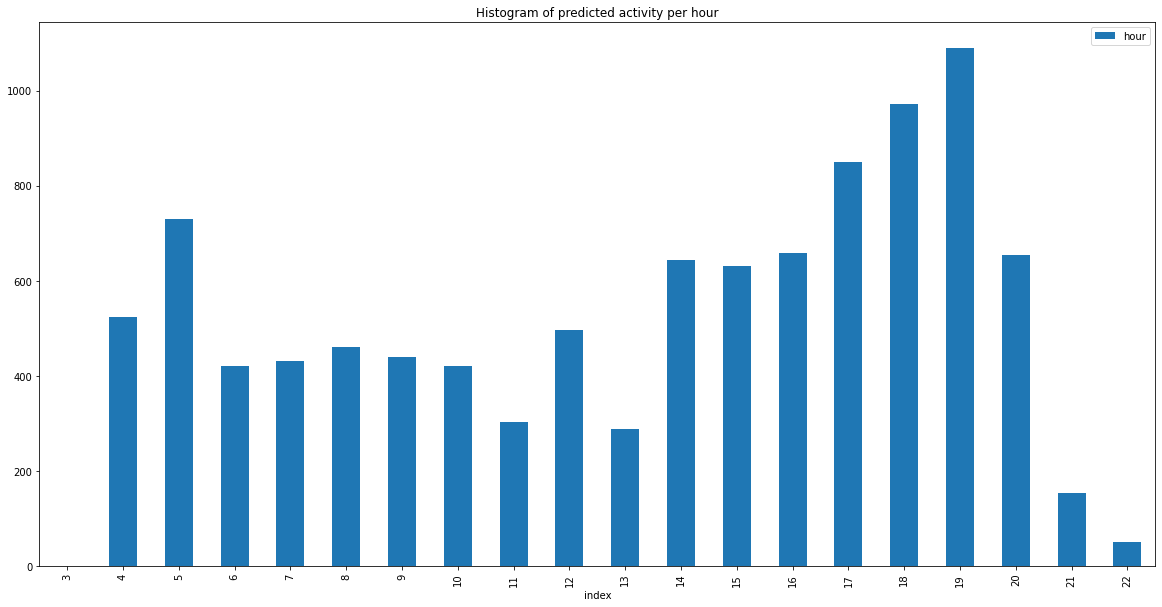

In [77]:
pd.DataFrame(house1_power_blk2_res.loc[house1_power_blk2_res['activity_pred'] > 0, 'hour'].astype(int).value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='hour', figsize=(20,10), legend='Histogramme activité=f(heure)', title='Histogram of predicted activity per hour');

In [78]:
house2_power_blk1_res = house2_power_blk1.copy()
house2_power_blk1_res['activity_pred'] = np.nan
house2_power_blk1_res['activity_pred'].iloc[train_dim_h2:-60] = (y_pred_h2[:, 0].reshape(-1) > 0.5).astype(int)
house2_power_blk1_res.iloc[train_dim_h2:-60].head()

/home/pierre/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,mains,activity,hour,activity_pred
datetime,,,,
2017-10-24 06:53:00,0.079947,1,6.883333,0.0
2017-10-24 06:54:00,0.099201,1,6.900000,0.0
2017-10-24 06:55:00,0.074445,1,6.916667,0.0
2017-10-24 06:56:00,0.076376,1,6.933333,0.0
2017-10-24 06:57:00,0.075961,1,6.950000,0.0


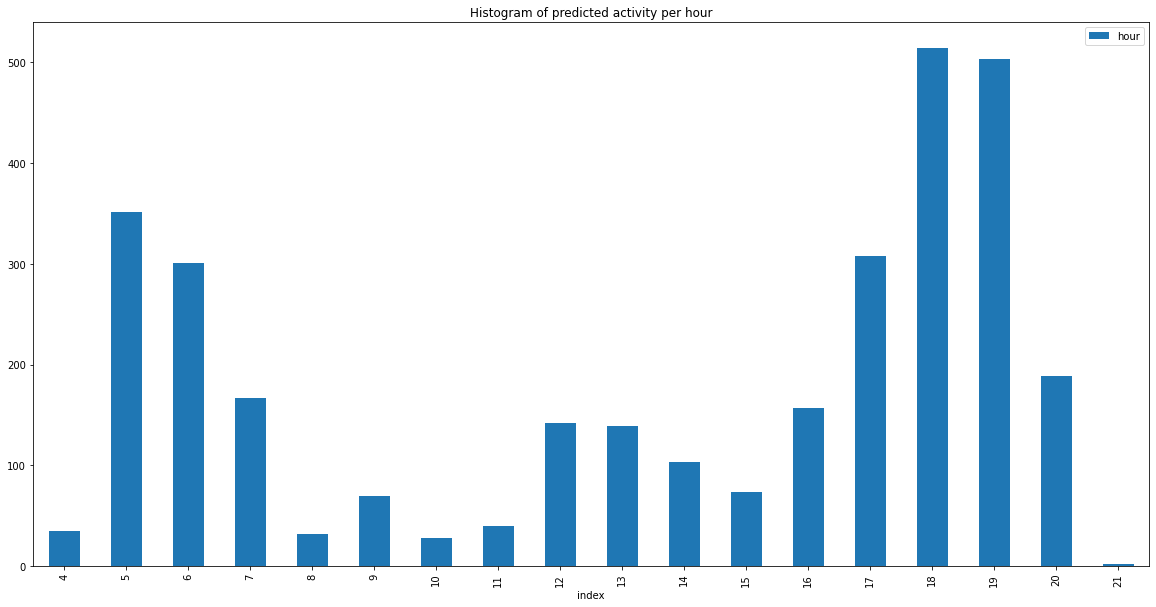

In [79]:
pd.DataFrame(house2_power_blk1_res.loc[house2_power_blk1_res['activity_pred'] > 0, 'hour'].astype(int).value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='hour', figsize=(20,10), legend='Histogramme activité=f(heure)', title='Histogram of predicted activity per hour');